<a href="https://colab.research.google.com/github/SLCFLAB/hd2025_time_series/blob/main/day2/Day2_var_granger_causality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAR

서울시의 기상데이터를 활용해서 VAR에 대한 실습을 진행하겠습니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings('ignore')

In [2]:
from urllib.parse import urljoin
data_repo_url = "https://raw.githubusercontent.com/SLCFLAB/hd2025_time_series/refs/heads/main/datasets/"
climate_data_path = urljoin(data_repo_url, "seoul_climate.csv")

In [3]:
data = pd.read_csv(climate_data_path, index_col=0, parse_dates=True)

# 필요한 변수만 선택하고 스케일 조정
df = data[['tavg', 'prcp', 'wspd', 'pres']].copy()
df.columns = ['Temperature', 'Precipitation', 'Wind_Speed', 'Pressure']

# 기압을 1000 hPa 기준으로 조정
df['Pressure'] = df['Pressure'] / 1000

# 결측치 처리 (선형 보간)
df = df.interpolate(method='linear').dropna()

print(f"\nData loaded successfully!")
print(f"Location: Seoul, South Korea")
print(f"Period: {df.index[0].date()} to {df.index[-1].date()}")
print(f"Number of observations: {len(df)}")
print("\nFirst few rows:")
print(df.head(10))
print("\nBasic statistics:")
print(df.describe())


Data loaded successfully!
Location: Seoul, South Korea
Period: 2020-01-02 to 2024-12-31
Number of observations: 1826

First few rows:
            Temperature  Precipitation  Wind_Speed  Pressure
time                                                        
2020-01-02          1.0       0.000000         0.0    1.0295
2020-01-03          0.2       0.000000         0.8    1.0273
2020-01-04          1.5       4.450000         0.9    1.0258
2020-01-05          2.5       8.900000         0.4    1.0302
2020-01-06          4.2      13.350000         2.8    1.0266
2020-01-07          6.2      17.800000         2.4    1.0119
2020-01-08          1.6      41.900000         2.0    1.0119
2020-01-09         -1.5       0.000000         1.0    1.0240
2020-01-10          0.2       0.045455         1.3    1.0240
2020-01-11          0.6       0.090909         3.0    1.0203

Basic statistics:
       Temperature  Precipitation   Wind_Speed     Pressure
count  1826.000000    1826.000000  1826.000000  1826.0


Step 1: Data Visualization


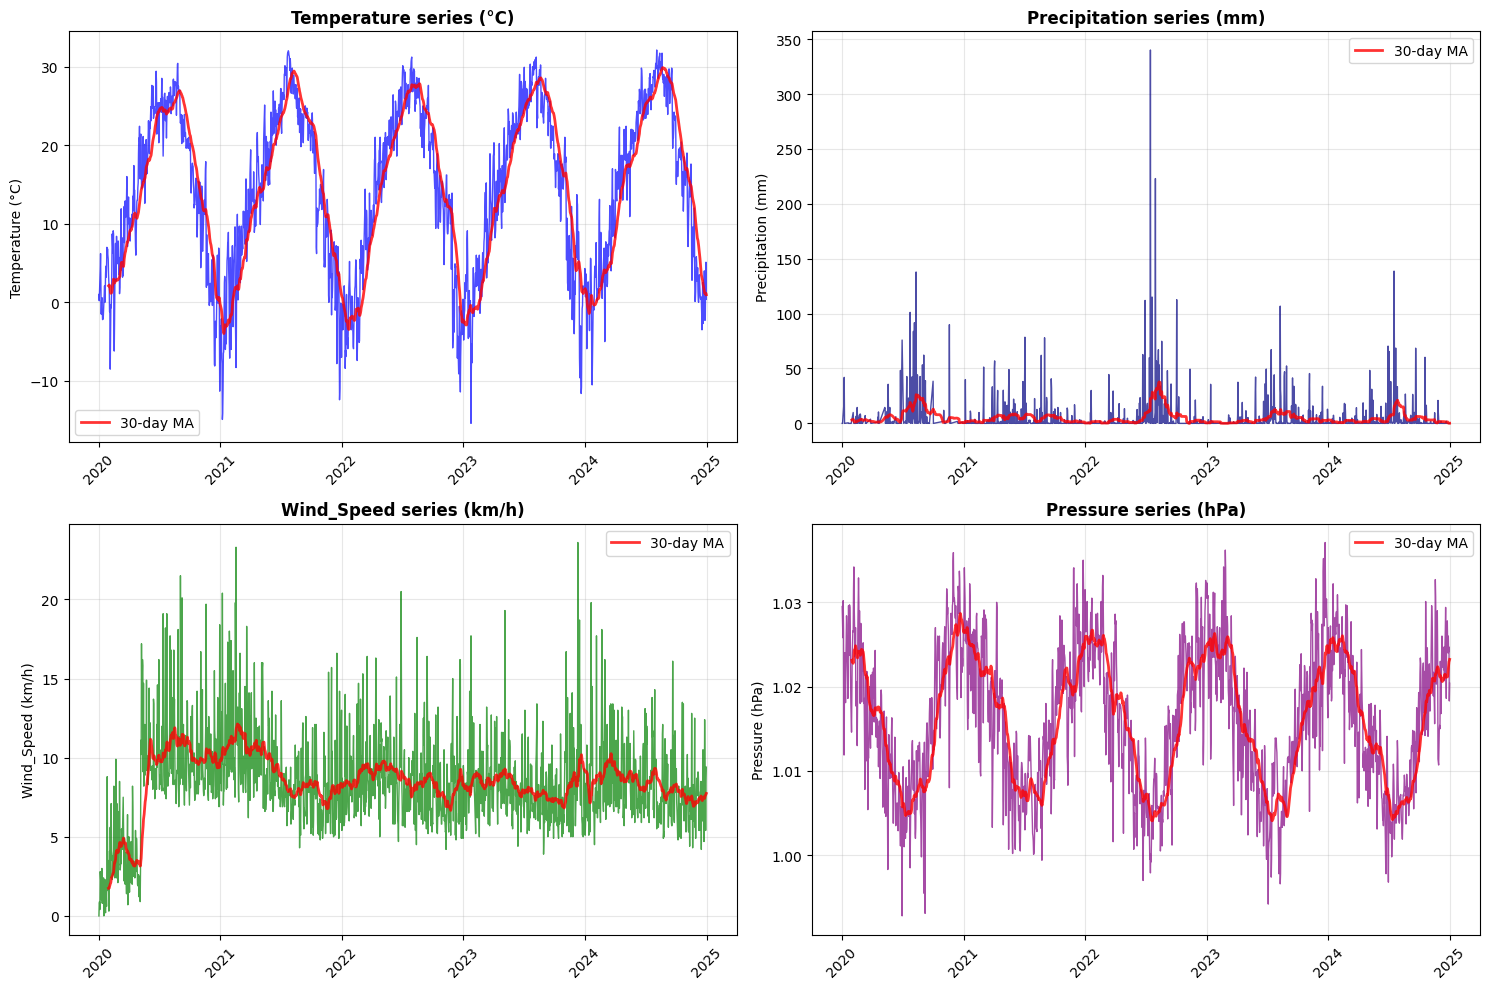

In [4]:
## 2. 데이터 시각화
print("\n" + "=" * 70)
print("Step 1: Data Visualization")
print("=" * 70)

# 원본 시계열 데이터
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

variable_info = {
    'Temperature': ('°C', 'blue'),
    'Precipitation': ('mm', 'navy'),
    'Wind_Speed': ('km/h', 'green'),
    'Pressure': ('hPa', 'purple')
}

for idx, col in enumerate(df.columns):
    unit, color = variable_info[col]
    axes[idx].plot(df.index, df[col], linewidth=1, alpha=0.7, color=color)
    # 30일 이동평균 추가
    axes[idx].plot(df.index, df[col].rolling(30).mean(),
                   linewidth=2, color='red', alpha=0.8, label='30-day MA')
    axes[idx].set_title(f'{col} series ({unit})', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(f'{col} ({unit})', fontsize=10)
    axes[idx].legend(loc='best')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

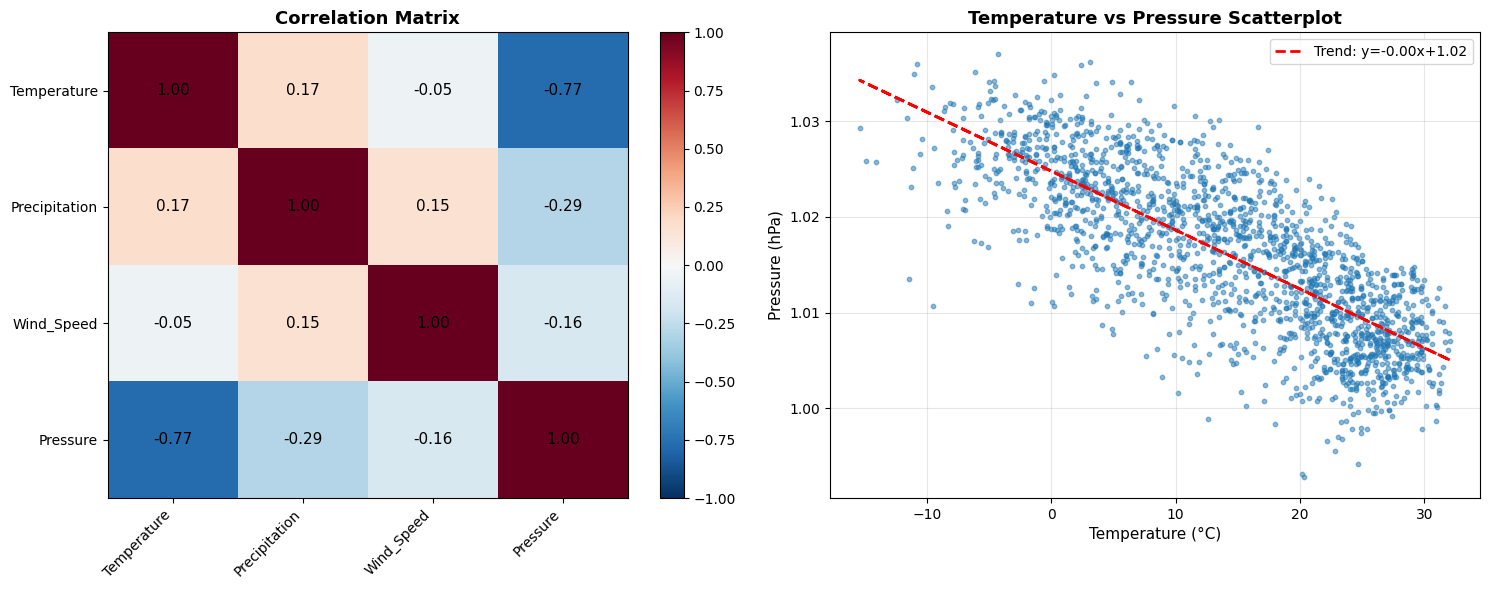

In [5]:
# 상관관계 분석
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 상관관계 행렬
correlation = df.corr()
im = axes[0].imshow(correlation, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
axes[0].set_xticks(range(len(df.columns)))
axes[0].set_yticks(range(len(df.columns)))
axes[0].set_xticklabels(df.columns, rotation=45, ha='right')
axes[0].set_yticklabels(df.columns)

for i in range(len(df.columns)):
    for j in range(len(df.columns)):
        text = axes[0].text(j, i, f'{correlation.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=11)

axes[0].set_title('Correlation Matrix', fontsize=13, fontweight='bold')
plt.colorbar(im, ax=axes[0])

# 산점도 매트릭스 (예시: 온도 vs 두 번째 변수)
second_var = df.columns[3]  # Humidity 또는 Pressure
axes[1].scatter(df['Temperature'], df[second_var], alpha=0.5, s=10)
axes[1].set_xlabel('Temperature (°C)', fontsize=11)
axes[1].set_ylabel(f'{second_var} ({variable_info[second_var][0]})', fontsize=11)
axes[1].set_title(f'Temperature vs {second_var} Scatterplot', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# 추세선 추가
z = np.polyfit(df['Temperature'], df[second_var], 1)
p = np.poly1d(z)
axes[1].plot(df['Temperature'], p(df['Temperature']),
             "r--", linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

In [6]:
def check_stationarity(data, column_name):
    """ADF 검정으로 정상성 확인"""
    result = adfuller(data.dropna(), autolag='AIC')

    print(f"\n{column_name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print(f"  Critical Value (1%): {result[4]['1%']:.4f}")
    print(f"  Critical Value (5%): {result[4]['5%']:.4f}")

    is_stationary = result[1] < 0.05
    if is_stationary:
        print(f"  ✓ STATIONARY (p < 0.05)")
    else:
        print(f"  ✗ NON-STATIONARY (p >= 0.05)")

    return is_stationary

# 원본 데이터 정상성 검정
print("\nTesting original data:")
print("-" * 70)
stationarity_results = {}
for col in df.columns:
    stationarity_results[col] = check_stationarity(df[col], col)

# 차분 데이터 생성
print("\n" + "=" * 70)
print("Creating differenced data for stationarity")
print("=" * 70)

df_diff = df.diff().dropna()

print("\nTesting differenced data:")
print("-" * 70)
diff_stationarity = {}
for col in df_diff.columns:
    diff_stationarity[col] = check_stationarity(df_diff[col], f"{col} (differenced)")

# 분석용 데이터 선택
if all(stationarity_results.values()):
    analysis_df = df
    print("\n=> Using ORIGINAL data for VAR model")
else:
    analysis_df = df_diff
    print("\n=> Using DIFFERENCED data for VAR model")

print(f"\nAnalysis data shape: {analysis_df.shape}")
print(f"Date range: {analysis_df.index[0].date()} to {analysis_df.index[-1].date()}")


Testing original data:
----------------------------------------------------------------------

Temperature:
  ADF Statistic: -2.0344
  p-value: 0.2717
  Critical Value (1%): -3.4340
  Critical Value (5%): -2.8631
  ✗ NON-STATIONARY (p >= 0.05)

Precipitation:
  ADF Statistic: -5.1548
  p-value: 0.0000
  Critical Value (1%): -3.4340
  Critical Value (5%): -2.8631
  ✓ STATIONARY (p < 0.05)

Wind_Speed:
  ADF Statistic: -5.3991
  p-value: 0.0000
  Critical Value (1%): -3.4340
  Critical Value (5%): -2.8631
  ✓ STATIONARY (p < 0.05)

Pressure:
  ADF Statistic: -3.1413
  p-value: 0.0236
  Critical Value (1%): -3.4340
  Critical Value (5%): -2.8631
  ✓ STATIONARY (p < 0.05)

Creating differenced data for stationarity

Testing differenced data:
----------------------------------------------------------------------

Temperature (differenced):
  ADF Statistic: -13.5582
  p-value: 0.0000
  Critical Value (1%): -3.4340
  Critical Value (5%): -2.8631
  ✓ STATIONARY (p < 0.05)

Precipitation (diff

In [7]:
## 4. VAR 모델 차수 선택
print("\n" + "=" * 70)
print("Step 3: VAR Model Order Selection")
print("=" * 70)

model = VAR(analysis_df)
lag_order = model.select_order(maxlags=15)

print("\nInformation Criteria for Lag Selection:")
print("-" * 70)
print(lag_order.summary())

# 최적 차수 선택
optimal_lag = lag_order.bic
print(f"\n✓ Selected lag order:")
print(f"  AIC suggests: {lag_order.aic}")
print(f"  BIC suggests: {lag_order.bic}")
print(f"  HQIC suggests: {lag_order.hqic}")
print(f"  FPE suggests: {lag_order.fpe}")
print(f"\n=> Using lag order: {optimal_lag} (based on BIC)")


Step 3: VAR Model Order Selection

Information Criteria for Lag Selection:
----------------------------------------------------------------------
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -1.263      -1.251      0.2827      -1.259
1       -1.848      -1.787      0.1576      -1.825
2       -2.179      -2.070      0.1131      -2.139
3       -2.331      -2.173     0.09717      -2.273
4       -2.447     -2.240*     0.08659      -2.370
5       -2.490      -2.235     0.08288      -2.396
6       -2.518      -2.214     0.08065      -2.406
7       -2.548      -2.196     0.07823      -2.418
8       -2.566      -2.165     0.07681      -2.418
9       -2.594      -2.144     0.07471     -2.428*
10      -2.605      -2.107     0.07390      -2.421
11      -2.601      -2.054     0.07419      -2.399
12      -2.608      -2.012     0.07369      -2.388
13      -2.603      -1.959     0.0740

In [8]:
## 5. VAR 모델 추정
print("\n" + "=" * 70)
print("Step 4: VAR Model Estimation")
print("=" * 70)

var_model = model.fit(optimal_lag)
print(f"\nVAR({optimal_lag}) Model Summary:")
print("=" * 70)
print(var_model.summary())


Step 4: VAR Model Estimation

VAR(4) Model Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 10, Oct, 2025
Time:                     07:03:33
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -2.24395
Nobs:                     1821.00    HQIC:                  -2.37373
Log likelihood:          -8037.19    FPE:                  0.0863284
AIC:                     -2.44960    Det(Omega_mle):       0.0831786
--------------------------------------------------------------------
Results for equation Temperature
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.000291         0.060414           -0.005           0.996
L1.Temperature          -0.062854         0.026433           -2.378      

In [9]:
## 6. 모델 진단

# Durbin-Watson 검정
print("\nDurbin-Watson Test (target: ~2.0, acceptable: 1.5-2.5):")
print("-" * 70)
dw_stats = durbin_watson(var_model.resid)
for idx, col in enumerate(analysis_df.columns):
    dw_value = dw_stats[idx]
    status = "✓ Good" if 1.5 < dw_value < 2.5 else "⚠ Check autocorrelation"
    print(f"  {col:20s}: {dw_value:.4f}  {status}")


Durbin-Watson Test (target: ~2.0, acceptable: 1.5-2.5):
----------------------------------------------------------------------
  Temperature         : 2.0105  ✓ Good
  Precipitation       : 2.0758  ✓ Good
  Wind_Speed          : 2.0212  ✓ Good
  Pressure            : 2.0208  ✓ Good


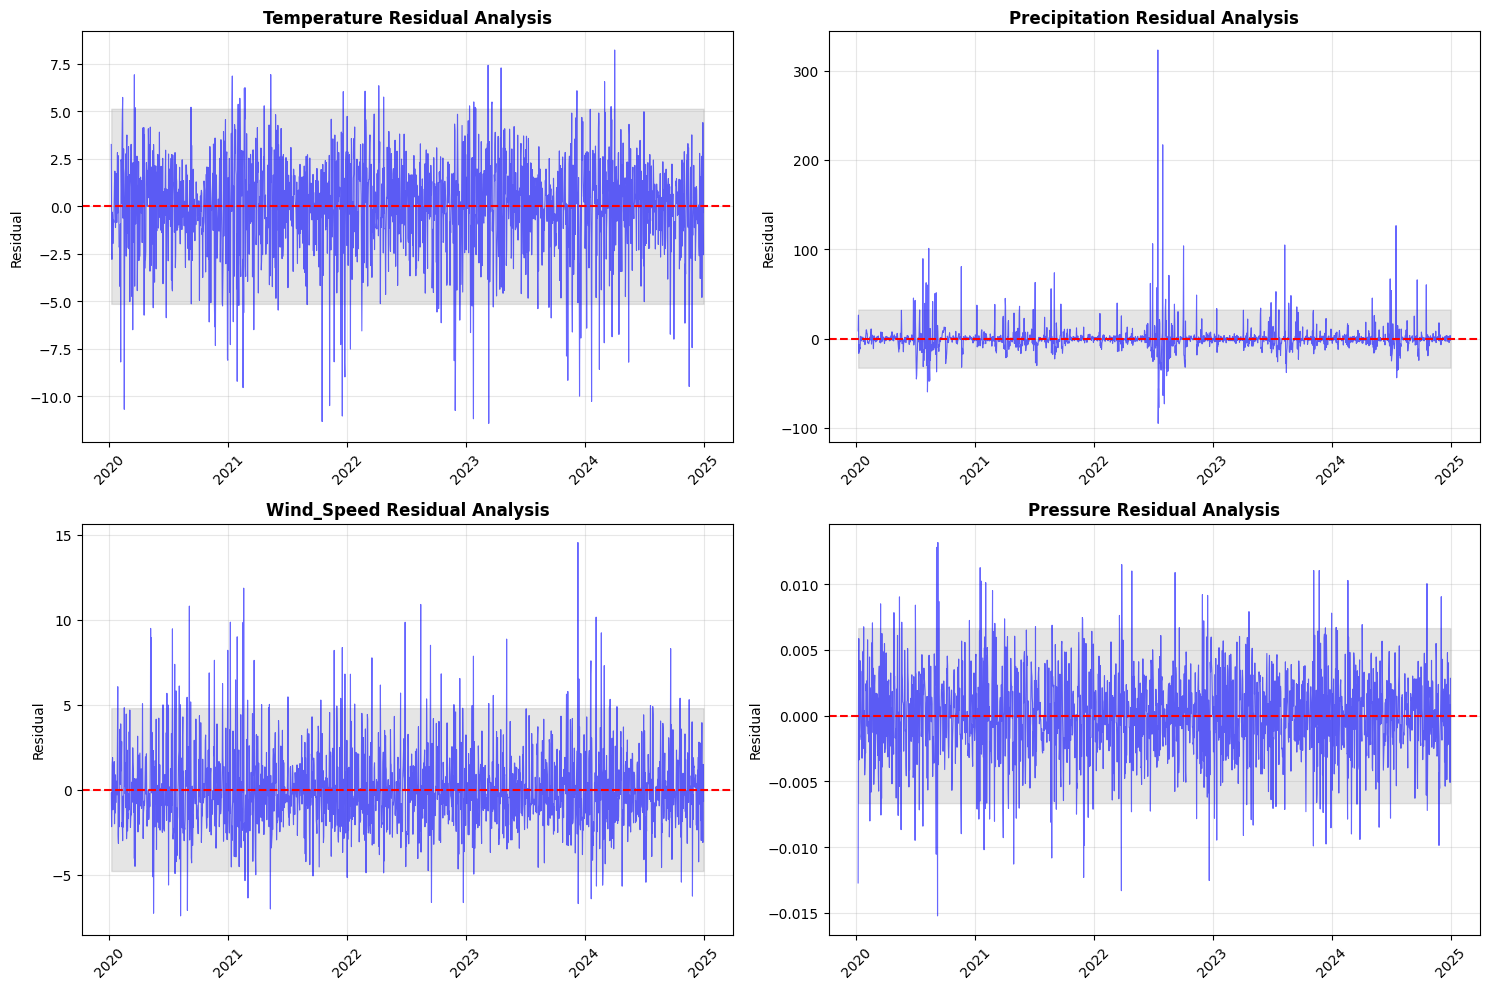

In [10]:
# 잔차 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(analysis_df.columns):
    # 잔차 시계열
    axes[idx].plot(var_model.resid.index, var_model.resid[col],
                   linewidth=0.8, alpha=0.6, color='blue')
    axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=1.5)
    axes[idx].fill_between(var_model.resid.index,
                           -2*var_model.resid[col].std(),
                           2*var_model.resid[col].std(),
                           alpha=0.2, color='gray')
    axes[idx].set_title(f'{col} Residual Analysis', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Residual', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

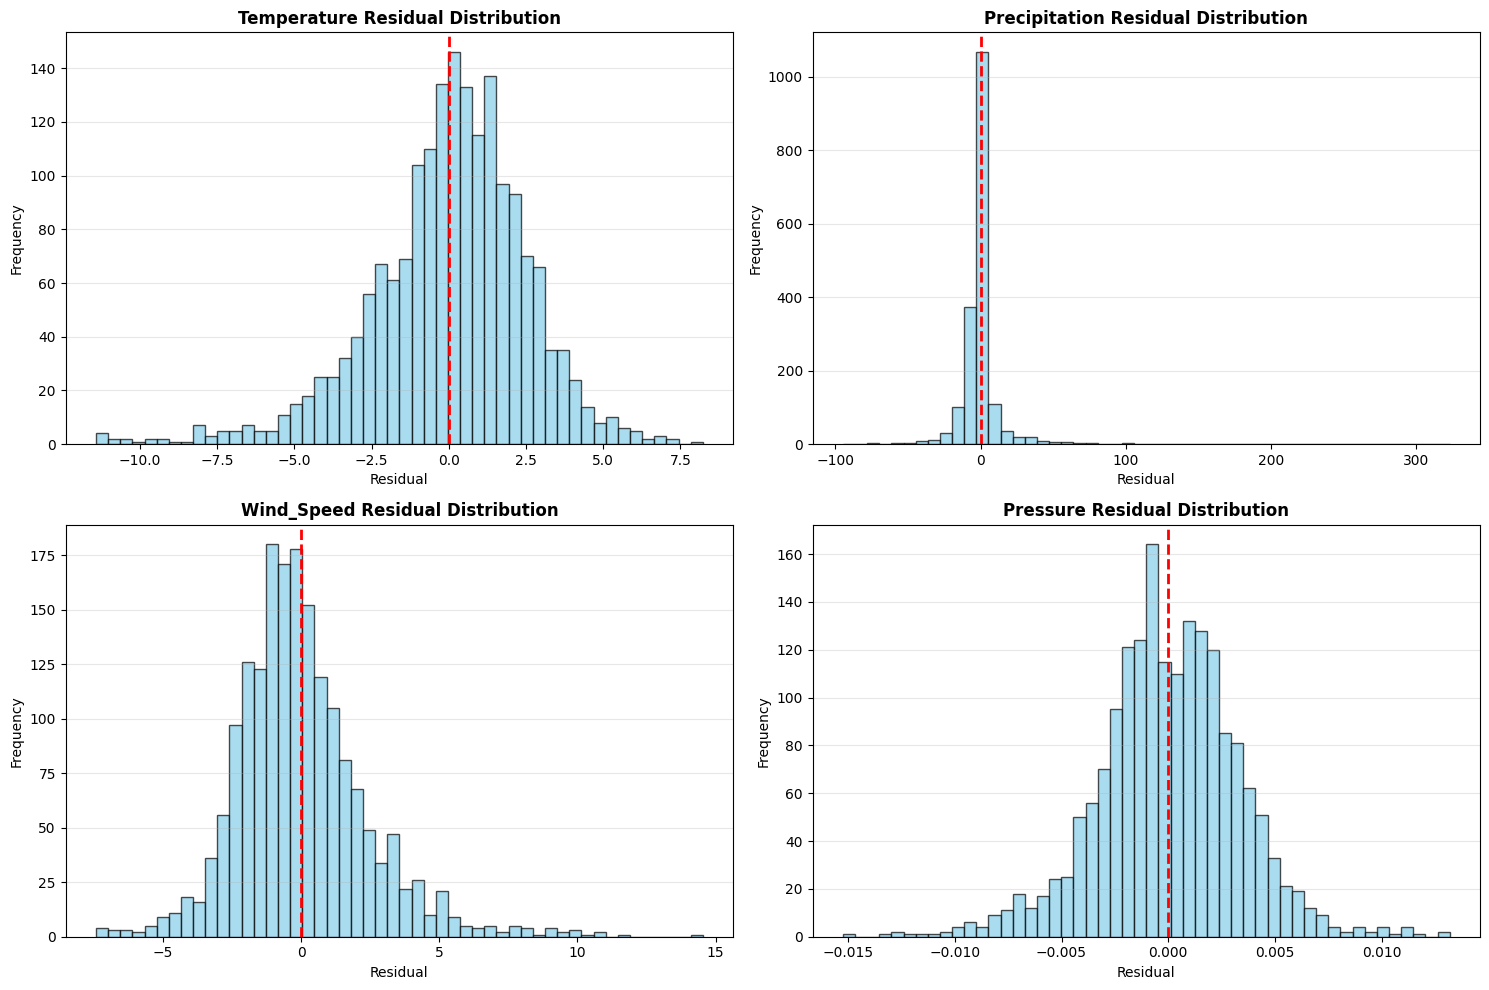

In [11]:
# 잔차 히스토그램
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(analysis_df.columns):
    axes[idx].hist(var_model.resid[col], bins=50, alpha=0.7,
                   color='skyblue', edgecolor='black')
    axes[idx].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[idx].set_title(f'{col} Residual Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Residual', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [12]:
## 7. Granger Causality 검정
print("\n" + "=" * 70)
print("Step 6: Granger Causality Test")
print("=" * 70)

# 온도에 대한 다른 변수들의 영향
print("\nTest 1: Do other variables Granger-cause Temperature?")
print("-" * 70)
granger_result_1 = var_model.test_causality('Temperature',
                                            ['Precipitation', 'Wind_Speed', 'Pressure'],
                                            kind='f')
print(granger_result_1.summary())

if granger_result_1.pvalue < 0.05:
    print("\n✓ Other variables Granger-causes Temperature")
else:
    print("\n✗ Other variables do not Granger-causes Temperature")

# 강수량에 대한 다른 변수들의 영향
print("\nTest 2: Do other variables Granger-cause Precipitation?")
print("-" * 70)
granger_result_2 = var_model.test_causality('Precipitation',
                                            ['Temperature', 'Wind_Speed', 'Pressure'],
                                            kind='f')
print(granger_result_2.summary())

if granger_result_2.pvalue < 0.05:
    print("\n✓ Other variables Granger-causes Precipitation")
else:
    print("\n✗ Other variables do not Granger-causes Precipitation")


Step 6: Granger Causality Test

Test 1: Do other variables Granger-cause Temperature?
----------------------------------------------------------------------
Granger causality F-test. H_0: ['Precipitation', 'Wind_Speed', 'Pressure'] do not Granger-cause Temperature. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value          df         
----------------------------------------------------------
         6.111          1.754   0.000 (12, np.int64(7216))
----------------------------------------------------------

✓ Other variables Granger-causes Temperature

Test 2: Do other variables Granger-cause Precipitation?
----------------------------------------------------------------------
Granger causality F-test. H_0: ['Temperature', 'Wind_Speed', 'Pressure'] do not Granger-cause Precipitation. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value          df         
---------------------------------------------------------


Step 7: Impulse Response Function (IRF)


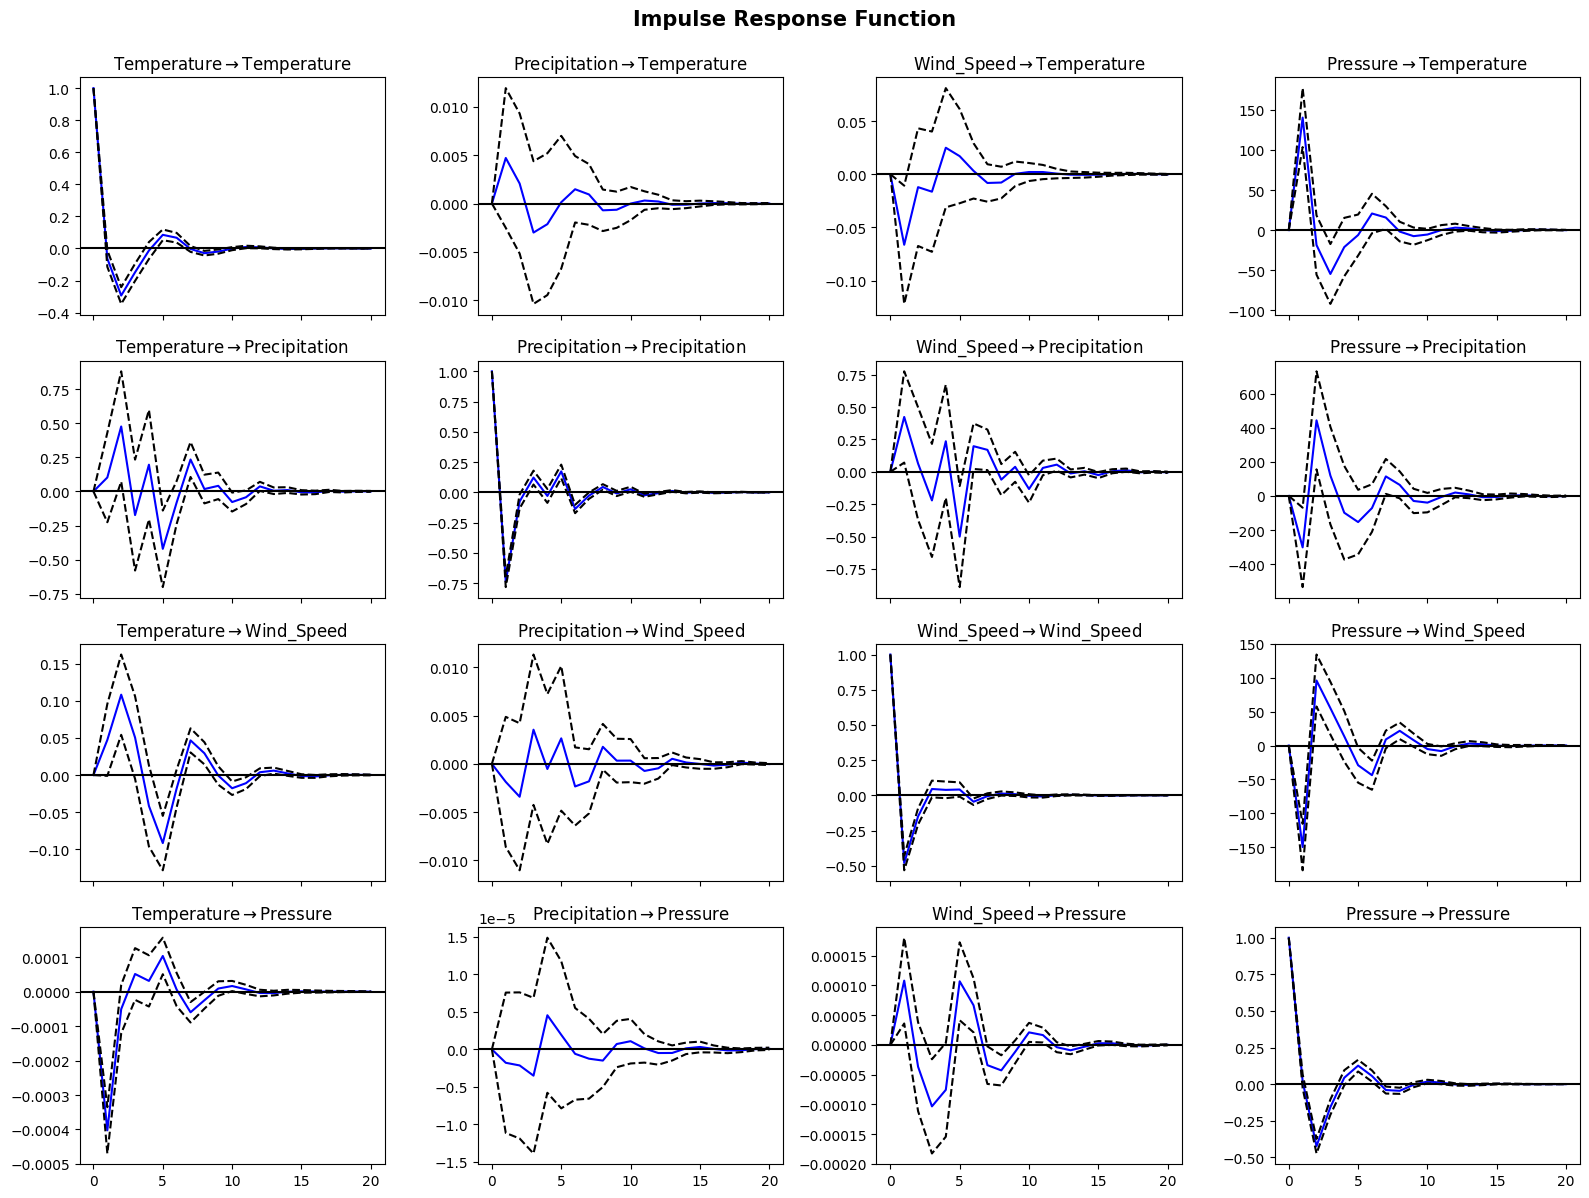

In [13]:
## 8. 충격 반응 함수 (Impulse Response Function)
print("\n" + "=" * 70)
print("Step 7: Impulse Response Function (IRF)")
print("=" * 70)

irf = var_model.irf(20)

fig = irf.plot(orth=False, figsize=(16, 12))
plt.suptitle('Impulse Response Function',
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

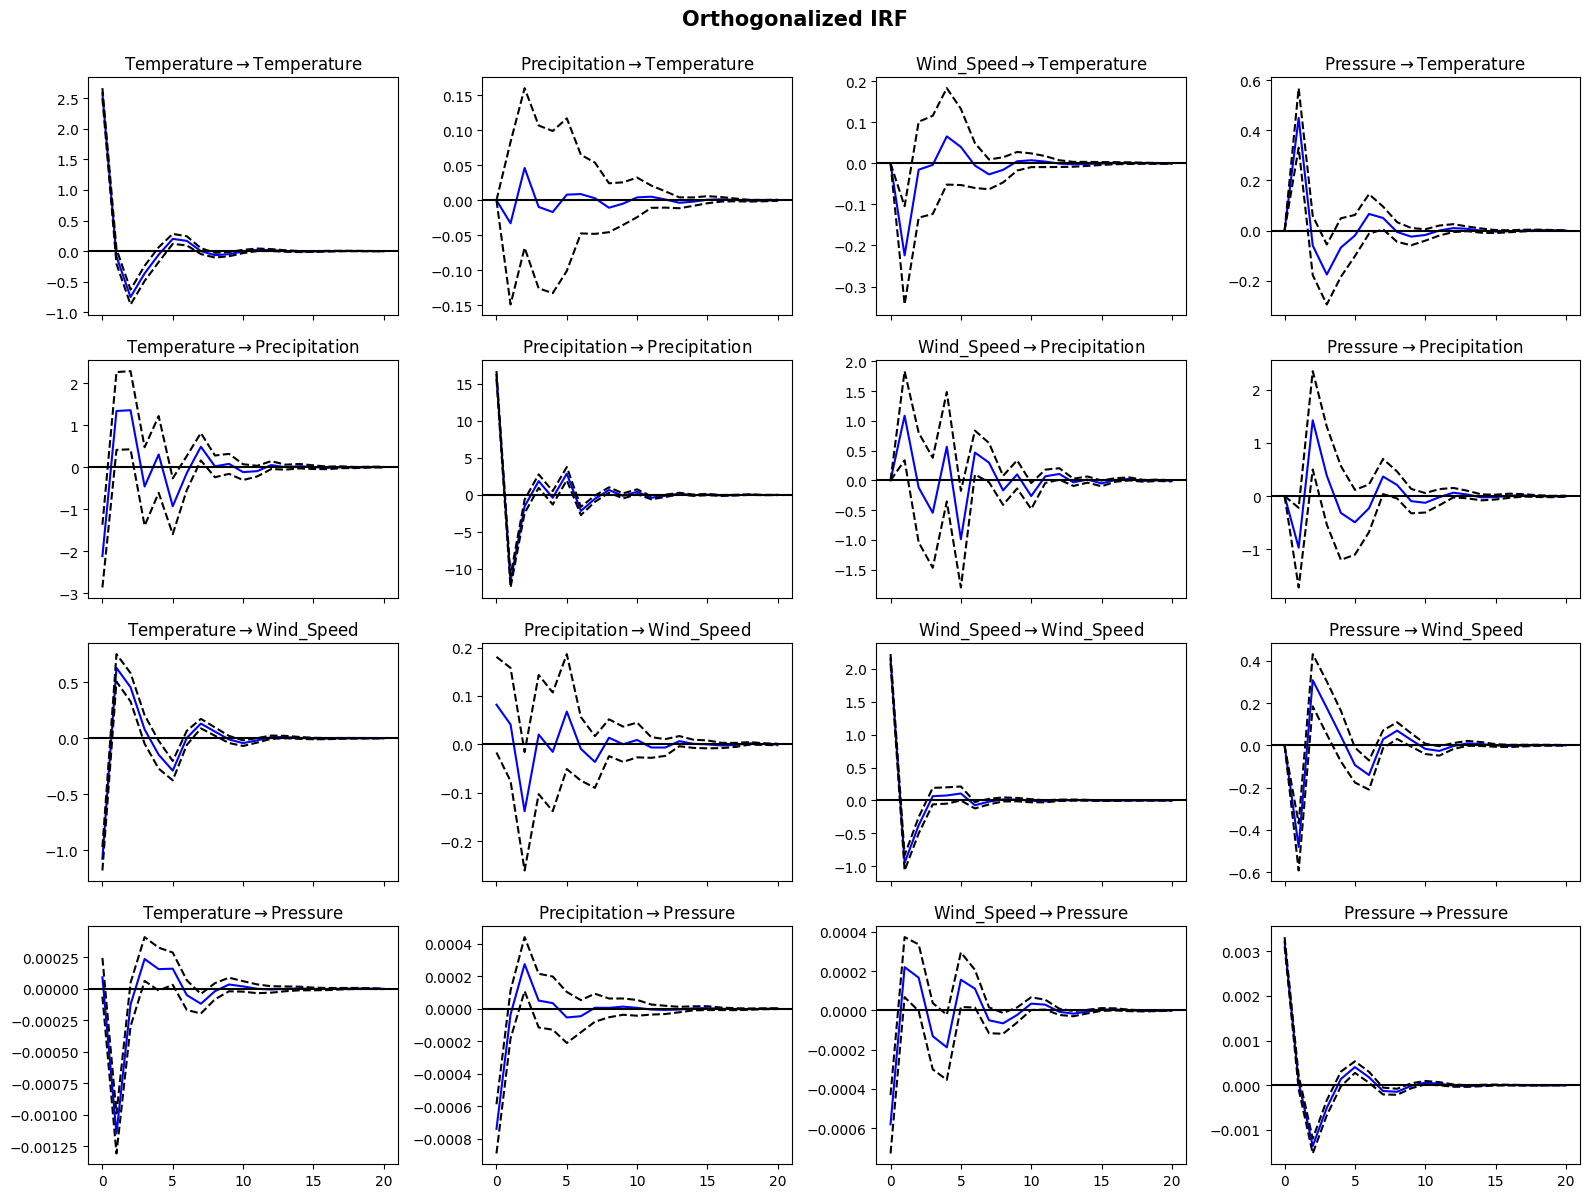

In [14]:
# 직교 IRF (Orthogonalized IRF)
irf_orth = var_model.irf(20)
fig = irf_orth.plot(orth=True, figsize=(16, 12))
plt.suptitle('Orthogonalized IRF',
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [15]:
print("\nIRF interpretation example:")
print("-" * 70)
print("Period 0-5 response of Temperature to Precipitation shock:")
for i in range(6):
    response = irf.irfs[i,
                        analysis_df.columns.get_loc('Temperature'),
                        analysis_df.columns.get_loc('Precipitation')]
    print(f"  Period {i}: {response:.6f}")


IRF interpretation example:
----------------------------------------------------------------------
Period 0-5 response of Temperature to Precipitation shock:
  Period 0: 0.000000
  Period 1: 0.004703
  Period 2: 0.002066
  Period 3: -0.002998
  Period 4: -0.002130
  Period 5: 0.000134



Step 8: Forecast Error Variance Decomposition (FEVD)


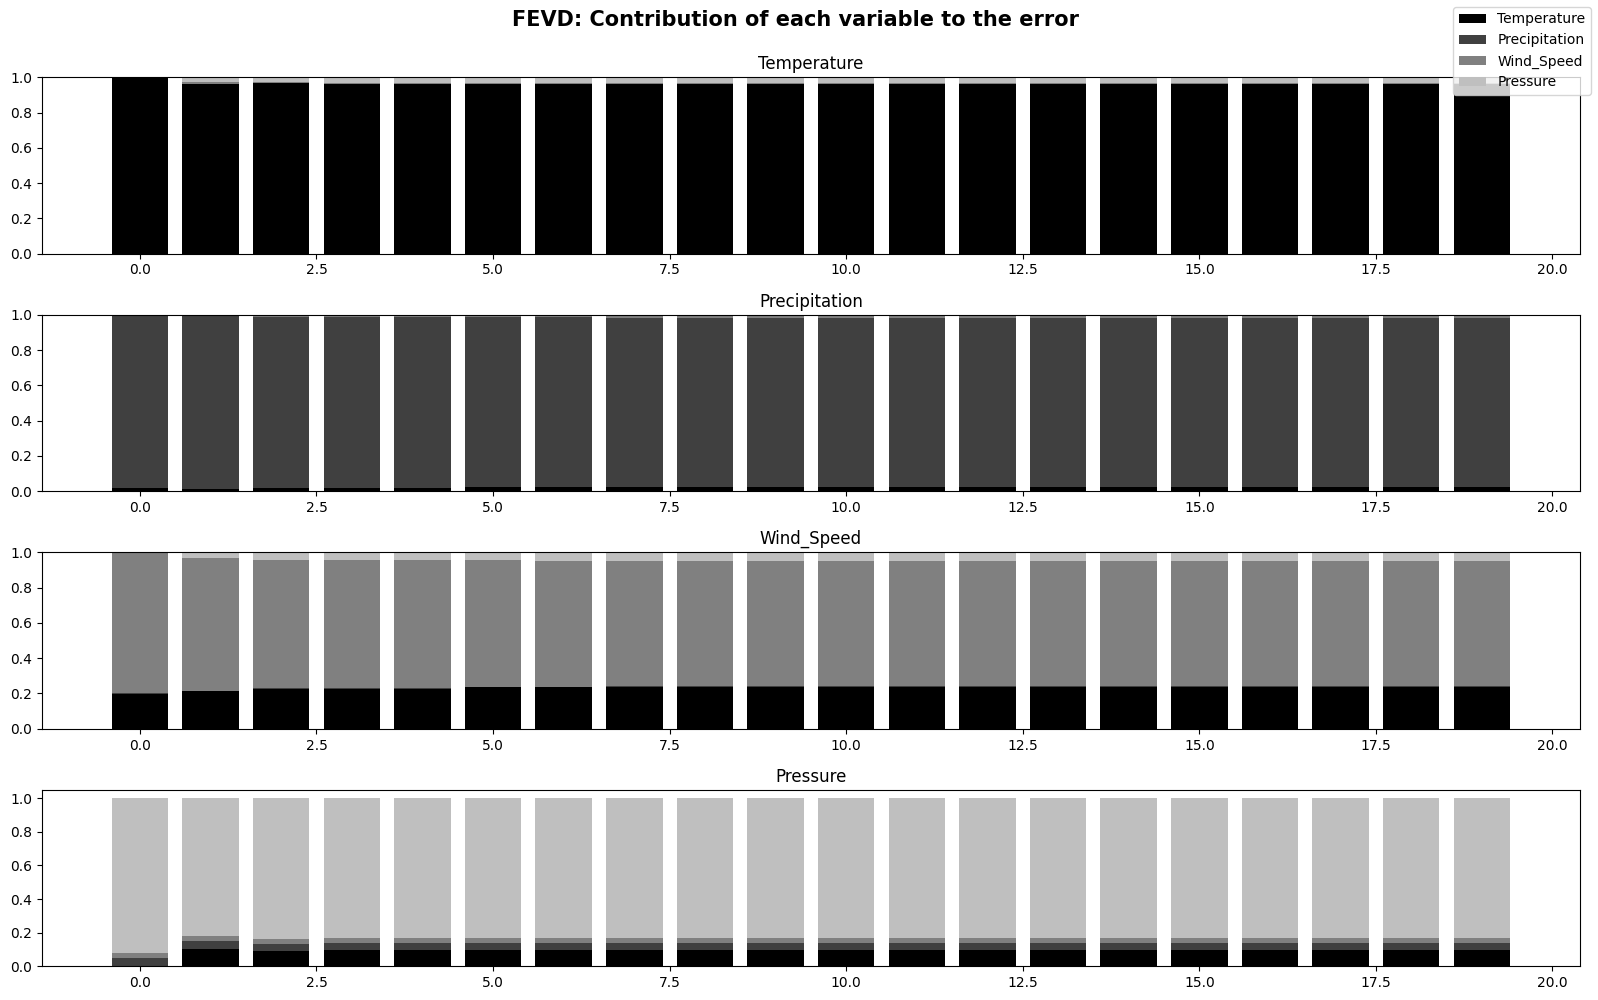

In [16]:
## 9. 예측 오차 분산 분해 (FEVD)
print("\n" + "=" * 70)
print("Step 8: Forecast Error Variance Decomposition (FEVD)")
print("=" * 70)

fevd = var_model.fevd(20)

fig = fevd.plot(figsize=(16, 10))
plt.suptitle('FEVD: Contribution of each variable to the error',
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [17]:
## 10. 예측 (Forecasting)
print("\n" + "=" * 70)
print("Step 9: Out-of-Sample Forecasting")
print("=" * 70)

# 향후 30일 예측
forecast_steps = 30
lag_order_val = var_model.k_ar
forecast = var_model.forecast(analysis_df.values[-lag_order_val:], steps=forecast_steps)

# 예측 결과를 DataFrame으로 변환
forecast_index = pd.date_range(start=analysis_df.index[-1],
                               periods=forecast_steps+1, freq='D')[1:]
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=analysis_df.columns)

print(f"\nForecast for next {forecast_steps} days:")
print("-" * 70)
print(forecast_df.head(15))


Step 9: Out-of-Sample Forecasting

Forecast for next 30 days:
----------------------------------------------------------------------
            Temperature  Precipitation  Wind_Speed  Pressure
2025-01-01    -0.682920       0.176640   -0.718297  0.003347
2025-01-02     0.426083      -0.257777   -0.336948 -0.000182
2025-01-03     0.647798       1.202234   -0.639427 -0.000690
2025-01-04     0.512490      -2.554783    0.174280 -0.000293
2025-01-05    -0.154190       0.827885    0.455687 -0.000199
2025-01-06    -0.307541       0.882372    0.083290  0.000167
2025-01-07    -0.106679      -0.323563   -0.118975  0.000197
2025-01-08     0.047812       0.339595   -0.106847 -0.000041
2025-01-09     0.086879      -0.633400   -0.018926 -0.000075
2025-01-10     0.040148      -0.063782    0.046291 -0.000010
2025-01-11    -0.018203       0.277753    0.039499  0.000017
2025-01-12    -0.030724      -0.010743    0.001612  0.000015
2025-01-13    -0.012568       0.081969   -0.007776 -0.000009
2025-01-14  

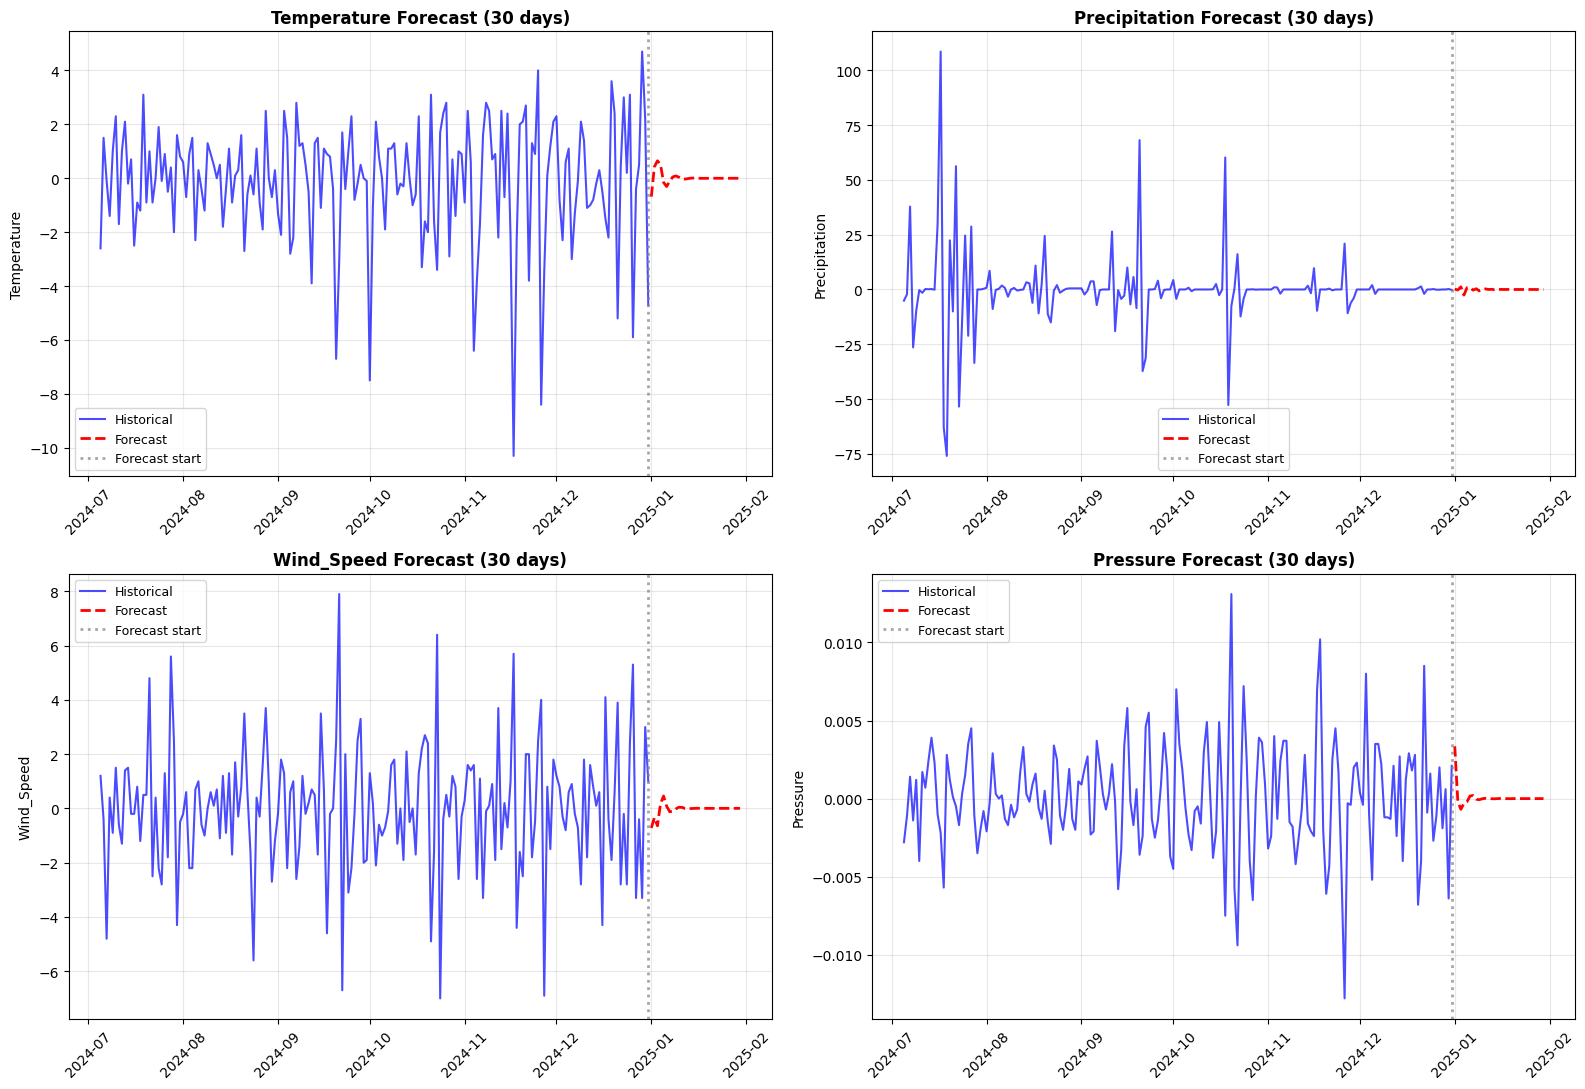

In [18]:
# 예측 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
axes = axes.flatten()

for idx, col in enumerate(analysis_df.columns):
    # 실제 데이터 (마지막 180일)
    axes[idx].plot(analysis_df.index[-180:], analysis_df[col].iloc[-180:],
                   label='Historical', linewidth=1.5, color='blue', alpha=0.7)
    # 예측 데이터
    axes[idx].plot(forecast_df.index, forecast_df[col],
                   label='Forecast', linewidth=2, color='red', linestyle='--')
    # 예측 시작점 표시
    axes[idx].axvline(x=analysis_df.index[-1], color='gray',
                     linestyle=':', linewidth=2, alpha=0.7, label='Forecast start')

    axes[idx].set_title(f'{col} Forecast (30 days)', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col, fontsize=10)
    axes[idx].legend(loc='best', fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Granger Causality

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
import warnings
warnings.filterwarnings('ignore')

In [22]:
gdp_data_path = urljoin(data_repo_url, "us_gdp.csv")
unemployment_data_path = urljoin(data_repo_url, "us_unemployment.csv")

gdp = pd.read_csv(gdp_data_path, index_col=0, parse_dates=True)
unemployment = pd.read_csv(unemployment_data_path, index_col=0, parse_dates=True)

In [23]:
df = pd.merge(gdp, unemployment, left_index=True, right_index=True, how='inner')
df.columns = ['GDP', 'Unemployment_Rate']

In [24]:
df

,GDP,Unemployment_Rate
DATE,,
1980-01-01,2789.842,6.3
1980-04-01,2797.352,6.9
1980-07-01,2856.483,7.8
1980-10-01,2985.557,7.5
1981-01-01,3124.206,7.5
...,...,...
2023-10-01,28424.722,3.9
2024-01-01,28708.161,3.7
2024-04-01,29147.044,3.9


In [25]:
# 선형 보간으로 월별 데이터로 변환
df = df.resample('MS').interpolate(method='linear')
df = df.dropna()

print(f"\nData loaded successfully!")
print(f"Period: {df.index[0].date()} to {df.index[-1].date()}")
print(f"Number of observations: {len(df)}")
print("\nFirst few rows:")
print(df.head())


Data loaded successfully!
Period: 1980-01-01 to 2024-10-01
Number of observations: 538

First few rows:
                    GDP  Unemployment_Rate
DATE                                      
1980-01-01  2789.842000                6.3
1980-02-01  2792.345333                6.5
1980-03-01  2794.848667                6.7
1980-04-01  2797.352000                6.9
1980-05-01  2817.062333                7.2


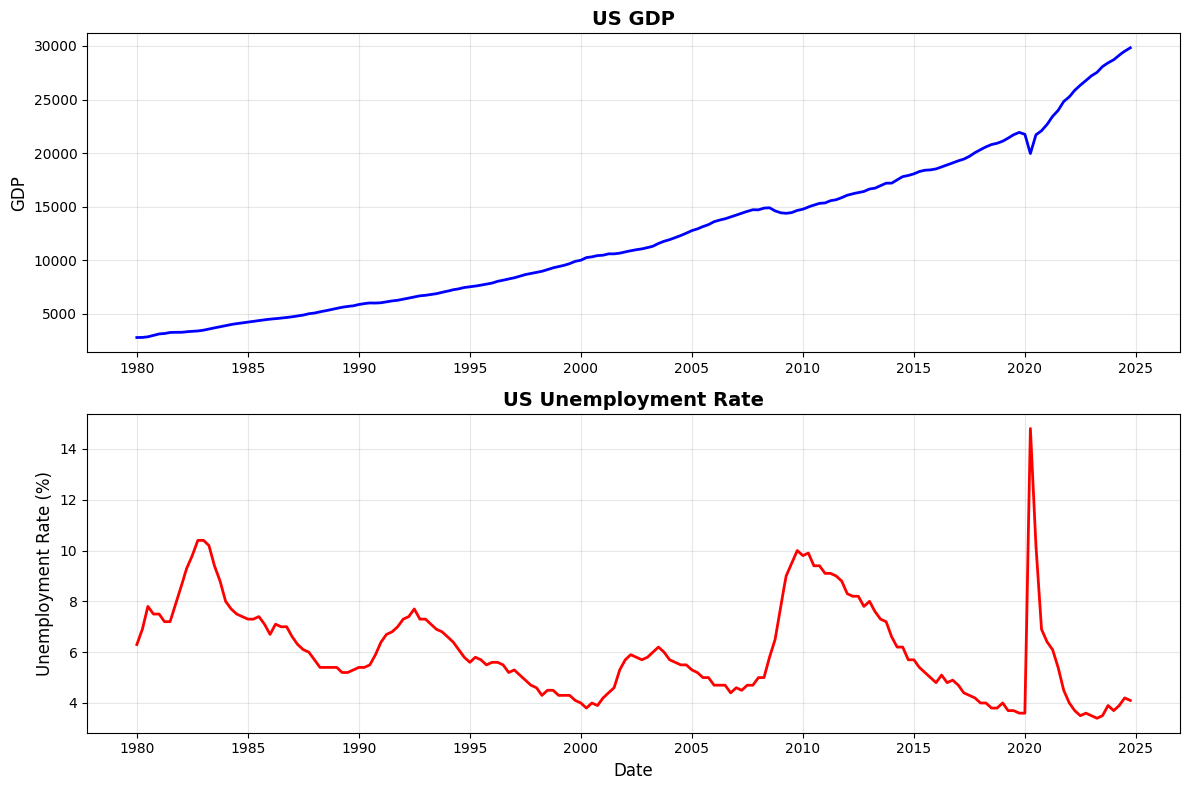

In [26]:
## 2. 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# GDP 시계열
axes[0].plot(df.index, df['GDP'], color='blue', linewidth=2)
axes[0].set_title('US GDP', fontsize=14, fontweight='bold')
axes[0].set_ylabel('GDP', fontsize=12)
axes[0].grid(True, alpha=0.3)

# 실업률 시계열
axes[1].plot(df.index, df['Unemployment_Rate'], color='red', linewidth=2)
axes[1].set_title('US Unemployment Rate', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Unemployment Rate (%)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
# 정상성 검정
def adf_test(series, name):
    """ADF 검정을 수행하고 결과를 출력하는 함수"""
    result = adfuller(series.dropna(), autolag='AIC')

    print(f"\n{name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print(f"  Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value:.4f}")

    if result[1] <= 0.05:
        print(f"  => {name} is STATIONARY (p-value <= 0.05)")
    else:
        print(f"  => {name} is NON-STATIONARY (p-value > 0.05)")

    return result[1] <= 0.05

# 원본 데이터에 대한 정상성 검정
is_gdp_stationary = adf_test(df['GDP'], 'GDP (Original)')
is_unemp_stationary = adf_test(df['Unemployment_Rate'], 'Unemployment Rate (Original)')


GDP (Original):
  ADF Statistic: 3.0348
  p-value: 1.0000
  Critical Values:
    1%: -3.4429
    5%: -2.8671
    10%: -2.5697
  => GDP (Original) is NON-STATIONARY (p-value > 0.05)

Unemployment Rate (Original):
  ADF Statistic: -2.9859
  p-value: 0.0362
  Critical Values:
    1%: -3.4430
    5%: -2.8671
    10%: -2.5698
  => Unemployment Rate (Original) is STATIONARY (p-value <= 0.05)


In [28]:
# 정상성을 만족하지 않으므로 차분 데이터 생성
df_diff = df.diff().dropna()

print("\n" + "-" * 60)
print("Testing differenced data:")
print("-" * 60)

is_gdp_diff_stationary = adf_test(df_diff['GDP'], 'GDP (Differenced)')
is_unemp_diff_stationary = adf_test(df_diff['Unemployment_Rate'], 'Unemployment Rate (Differenced)')

# 분석에 사용할 데이터 선택
if is_gdp_stationary and is_unemp_stationary:
    analysis_df = df
    print("\n=> Using ORIGINAL data for Granger Causality test")
else:
    analysis_df = df_diff
    print("\n=> Using DIFFERENCED data for Granger Causality test")


------------------------------------------------------------
Testing differenced data:
------------------------------------------------------------

GDP (Differenced):
  ADF Statistic: -3.4647
  p-value: 0.0089
  Critical Values:
    1%: -3.4429
    5%: -2.8671
    10%: -2.5697
  => GDP (Differenced) is STATIONARY (p-value <= 0.05)

Unemployment Rate (Differenced):
  ADF Statistic: -5.2562
  p-value: 0.0000
  Critical Values:
    1%: -3.4430
    5%: -2.8671
    10%: -2.5698
  => Unemployment Rate (Differenced) is STATIONARY (p-value <= 0.05)

=> Using DIFFERENCED data for Granger Causality test


In [29]:
## 4. Granger Causality Test

# 최적 시차 결정 (VAR 모델 사용)
print("\nDetermining optimal lag order...")
model = VAR(analysis_df)
lag_order_results = model.select_order(maxlags=12)
print("\nLag Order Selection Results:")
print(lag_order_results.summary())

optimal_lag = lag_order_results.bic
print(f"\nOptimal lag (based on BIC): {optimal_lag}")


Determining optimal lag order...

Lag Order Selection Results:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        5.570       5.586       262.3       5.576
1        4.056       4.105       57.75       4.075
2        3.975       4.056       53.24       4.007
3        3.811       3.924       45.19       3.855
4        2.944       3.090       18.99       3.001
5        2.938       3.116       18.87       3.008
6        2.924       3.135       18.61       3.006
7        2.654      2.898*       14.21       2.750
8        2.656       2.932       14.23       2.764
9        2.653       2.962       14.20       2.774
10      2.598*       2.939      13.44*      2.732*
11       2.604       2.978       13.52       2.751
12       2.608       3.014       13.58       2.767
--------------------------------------------------

Optimal lag (based on BIC): 7


In [30]:
# Granger Causality Test 수행
max_lag = min(optimal_lag + 2, 8) # 최대 8까지 고려

print(f"\n" + "=" * 60)
print(f"Testing: Does Unemployment Rate Granger-cause GDP?")
print("=" * 60)
gc_test_1 = grangercausalitytests(analysis_df[['GDP', 'Unemployment_Rate']],
                                   maxlag=max_lag, verbose=True)

print(f"\n" + "=" * 60)
print(f"Testing: Does GDP Granger-cause Unemployment Rate?")
print("=" * 60)
gc_test_2 = grangercausalitytests(analysis_df[['Unemployment_Rate', 'GDP']],
                                   maxlag=max_lag, verbose=True)


Testing: Does Unemployment Rate Granger-cause GDP?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=37.2451 , p=0.0000  , df_denom=533, df_num=1
ssr based chi2 test:   chi2=37.4547 , p=0.0000  , df=1
likelihood ratio test: chi2=36.2040 , p=0.0000  , df=1
parameter F test:         F=37.2451 , p=0.0000  , df_denom=533, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=30.2300 , p=0.0000  , df_denom=530, df_num=2
ssr based chi2 test:   chi2=61.0304 , p=0.0000  , df=2
likelihood ratio test: chi2=57.7933 , p=0.0000  , df=2
parameter F test:         F=30.2300 , p=0.0000  , df_denom=530, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=39.4843 , p=0.0000  , df_denom=527, df_num=3
ssr based chi2 test:   chi2=120.0264, p=0.0000  , df=3
likelihood ratio test: chi2=108.2695, p=0.0000  , df=3
parameter F test:         F=39.4843 , p=0.0000  , df_denom=527, df_num=3

Granger Causality
number of lags (no zero

In [31]:
## 5. 결과 요약
def summarize_granger_test(gc_test, name, max_lag):
    """Granger Causality 검정 결과를 요약하는 함수"""
    print(f"\n{name}:")
    print("-" * 60)

    significant_lags = []
    for lag in range(1, max_lag + 1):
        # F-test p-value 추출
        p_value = gc_test[lag][0]['ssr_ftest'][1]
        print(f"  Lag {lag}: p-value = {p_value:.4f}", end="")

        if p_value < 0.05:
            print(" => SIGNIFICANT (reject H0)")
            significant_lags.append(lag)
        else:
            print(" => NOT significant")

    if significant_lags:
        print(f"\n  ✓ Granger causality detected at lags: {significant_lags}")
    else:
        print(f"\n  ✗ No Granger causality detected")

    return len(significant_lags) > 0

In [32]:
result_1 = summarize_granger_test(gc_test_1,
                                   "Unemployment Rate → GDP",
                                   max_lag)
result_2 = summarize_granger_test(gc_test_2,
                                   "GDP → Unemployment Rate",
                                   max_lag)


Unemployment Rate → GDP:
------------------------------------------------------------
  Lag 1: p-value = 0.0000 => SIGNIFICANT (reject H0)
  Lag 2: p-value = 0.0000 => SIGNIFICANT (reject H0)
  Lag 3: p-value = 0.0000 => SIGNIFICANT (reject H0)
  Lag 4: p-value = 0.0000 => SIGNIFICANT (reject H0)
  Lag 5: p-value = 0.0000 => SIGNIFICANT (reject H0)
  Lag 6: p-value = 0.0000 => SIGNIFICANT (reject H0)
  Lag 7: p-value = 0.0000 => SIGNIFICANT (reject H0)
  Lag 8: p-value = 0.0000 => SIGNIFICANT (reject H0)

  ✓ Granger causality detected at lags: [1, 2, 3, 4, 5, 6, 7, 8]

GDP → Unemployment Rate:
------------------------------------------------------------
  Lag 1: p-value = 0.0024 => SIGNIFICANT (reject H0)
  Lag 2: p-value = 0.0003 => SIGNIFICANT (reject H0)
  Lag 3: p-value = 0.0000 => SIGNIFICANT (reject H0)
  Lag 4: p-value = 0.0000 => SIGNIFICANT (reject H0)
  Lag 5: p-value = 0.0000 => SIGNIFICANT (reject H0)
  Lag 6: p-value = 0.0000 => SIGNIFICANT (reject H0)
  Lag 7: p-value =

In [33]:
## 6. 최종 결론
if result_1 and result_2:
    print("\nBIDIRECTIONAL causality detected")
    print("  Both variables Granger-cause each other")
elif result_1:
    print("\nUNIDIRECTIONAL causality detected")
    print("  Unemployment Rate Granger-causes GDP")
elif result_2:
    print("\nUNIDIRECTIONAL causality detected")
    print("  GDP Granger-causes Unemployment Rate")
else:
    print("\nNO Granger causality detected")
    print("  Neither variable Granger-causes the other")


BIDIRECTIONAL causality detected
  Both variables Granger-cause each other
